In [105]:
import cv2
import numpy as np
import pandas as pd
import os
import sys
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from sklearn.metrics import classification_report

### Load dataframe

In [2]:
main_data = pd.read_csv("data_labels_mainData.csv")
extra_data = pd.read_csv("data_labels_extraData.csv")

### split data into different folders for different cell types

In [27]:
import shutil
root = os.getcwd()
source_dir = os.path.join(root, "patch_images")

for i, row in main_data.iterrows():
    image_name = row["ImageName"]
    cell_name = row["cellTypeName"]
    is_cancer = str(row["isCancerous"])

#     new_folder_multi = os.path.join(root,"multiclass_task", cell_name)
    new_folder_bin = os.path.join(root,"binary_task", is_cancer)

#     os.makedirs(new_folder_multi, exist_ok=True)
    os.makedirs(new_folder_bin, exist_ok=True)

    source = os.path.join(source_dir, image_name)

#     dest_multi = os.path.join(root, "multiclass_task",cell_name)
    dest_bin = os.path.join(root,"binary_task", is_cancer)

#     go = shutil.copy(source,dest_multi)
    go = shutil.copy(source, dest_bin)

### Add training data for cancerous classification from extra dataset 

In [15]:
import shutil
root = os.getcwd()
source_dir = os.path.join(root, "patch_images")

for i, row in extra_data.iterrows():
    image_name = row["ImageName"]
    is_cancer = str(row["isCancerous"])

    new_folder_bin = os.path.join(root, "binary_task",is_cancer)

    os.makedirs(new_folder_bin, exist_ok=True)

    source = os.path.join(source_dir, image_name)

    dest_bin = os.path.join(root, is_cancer)

    go = shutil.copy(source, dest_bin)

### Old load image code 

In [4]:
def get_images(img_list, path):    
    images = list()
    
    for img in img_list:
        img = cv2.imread(os.path.join(path, img))
        # resize to 0-1 for faster computation
        resized = img / 255
        images.append(resized)
        
    return images

images, cell_type, is_cancerous = get_images(main_data["ImageName"], "patch_images"), main_data[["cellType"]], main_data[["isCancerous"]]

print(len(images))
#print(images[0].shape)
print(len(cell_type))
print(len(is_cancerous))

9896
9896
9896


### Get data from splitted folder

In [3]:
import shutil
root = os.getcwd()
source_dir = os.path.join(root, "patch_images")

def cancerous_classify_data():    
    images = list()
    labels = list()
    
    for label in [0, 1]:
        # get image directory
        img_dir = os.path.join(root, "binary_task",f"{label}")
        
        for img in os.listdir(img_dir):
            img = cv2.imread(os.path.join(img_dir, img))
            # resize to 0-1 for faster computation
            resized = img / 255
            images.append(resized)
            labels.append(label)
        
    return (images, labels)


### Data augmentation 

In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

root = os.getcwd()
binary_root = os.path.join(root, "binary_task")
multiclass_root = os.path.join(root, "multiclass_task")

datagen = ImageDataGenerator()

### Base CNN model

In [35]:
images, cancer_label = cancerous_classify_data()

# try testing cancerous dataset
# x_train, x_test, y_train, y_test = train_test_split(
#     np.array(images), np.array(is_cancerous), test_size=0.2
# )

def get_model():
    model = tf.keras.Sequential()
    # First convo-pooling
    # Convolutional layers (filter the image with a kernel)
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=[27, 27, 3]))
    # Max-pooling layers (reduce the size of the image by choosing max pixel at certain area)
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    # Flatten input
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(128, activation="relu"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    # Output layer
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    # Compile model
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy", "AUC"])
    
    return model

# train data from manual load data
x_train, x_test, y_train, y_test = train_test_split(
    np.array(images), np.array(cancer_label), test_size=0.2
)

datagen = ImageDataGenerator(
    zca_whitening=True,
)
datagen.fit(np.array(images))

aug_train = datagen.flow(x_train, y_train, shuffle=True)
aug_val = datagen.flow(x_test, y_test, shuffle=True)

model = get_model()
# model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
model.fit(aug_train, epochs=10, validation_data=aug_val)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10


2022-05-05 11:49:18.572060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


248/248 [==============================] - ETA: 0s - loss: 0.4474 - accuracy: 0.7828 - auc: 0.8660

2022-05-05 11:49:36.971005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


248/248 [==============================] - 22s 87ms/step - loss: 0.4474 - accuracy: 0.7828 - auc: 0.8660 - val_loss: 0.3668 - val_accuracy: 0.8384 - val_auc: 0.9309
Epoch 2/10
248/248 [==============================] - 20s 81ms/step - loss: 0.2936 - accuracy: 0.8766 - auc: 0.9458 - val_loss: 0.3352 - val_accuracy: 0.8667 - val_auc: 0.9374
Epoch 3/10
248/248 [==============================] - 23s 92ms/step - loss: 0.2593 - accuracy: 0.8925 - auc: 0.9576 - val_loss: 0.3495 - val_accuracy: 0.8470 - val_auc: 0.9382
Epoch 4/10
248/248 [==============================] - 25s 102ms/step - loss: 0.2306 - accuracy: 0.9054 - auc: 0.9662 - val_loss: 0.3402 - val_accuracy: 0.8682 - val_auc: 0.9381
Epoch 5/10
248/248 [==============================] - 21s 84ms/step - loss: 0.2061 - accuracy: 0.9224 - auc: 0.9726 - val_loss: 0.3511 - val_accuracy: 0.8747 - val_auc: 0.9377
Epoch 6/10
248/248 [==============================] - 22s 87ms/step - loss: 0.1742 - accuracy: 0.9325 - auc: 0.9806 - val_loss: 0.

### Tune CNN model

Tunable parameters:
- Size of kernel of Convolution/Pooling Layers
- Strides of Convolution/Pooling Layers
- Activation function

In [48]:
x_train, x_test, y_train, y_test = train_test_split(
    np.array(images), np.array(cancer_label), test_size=0.2
)

def cnn_tuner(hp):
    model = tf.keras.Sequential()

    for i in range(hp.Int(f'no_cnn', 1, 4, step=1)):
        # Convolutional layers (filter the image with a kernel)
        model.add(tf.keras.layers.Conv2D(hp.Int(f'convo_filter_{i}', 16, 128, step=16), (3, 3), strides=1,activation=hp.Choice(f"activation_convo_{i}", ["relu", "sigmoid", "softmax", "tanh"]), input_shape=[27, 27, 3]))
        # Max-pooling layers (reduce the size of the image by choosing max pixel at certain area)
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=1,))
        
    # Flatten input
    model.add(tf.keras.layers.Flatten())

    # hidden layers
    for i in range(hp.Int('layers_no', 1, 4)):
        model.add(tf.keras.layers.Dense(hp.Int(f'hidden_layer_{i}', 32, 256, step=32), activation=hp.Choice(f"activation_hidden_{i}", ["relu", "sigmoid", "softmax", "tanh"])))
        
    # output layer
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))   
    # Compile model
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy", "AUC"])
    
    return model

# status.expect_partial()
              
tuner = kt.RandomSearch(cnn_tuner, objective="val_accuracy", max_trials=5)

tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
best_model = tuner.get_best_models()[0]

Trial 5 Complete [00h 00m 30s]
val_accuracy: 0.596969723701477

Best val_accuracy So Far: 0.8808081150054932
Total elapsed time: 00h 01m 54s
INFO:tensorflow:Oracle triggered exit


In [52]:
print(f"Best Convolution filter: {tuner.get_best_hyperparameters()[0].get('convo_filter')}")
print(f"Best number of hidden layer: {tuner.get_best_hyperparameters()[0].get('hidden_layer')}")

for i in range(tuner.get_best_hyperparameters()[0].get('cnn_no')):
    print(f"Best filter in CNN layer {i}: {tuner.get_best_hyperparameters()[0].get(f'convo_filter_{i}')}")
    print(f"Best filter in CNN layer {i}: {tuner.get_best_hyperparameters()[0].get(f"activation_convo_{i}")

for i in range(tuner.get_best_hyperparameters()[0].get('layers_no')):
    print(f"Best nodes in hidden layer {i}: {tuner.get_best_hyperparameters()[0].get(f'hidden_layer_{i}')}")
    print(f"Best activation in hidden layer {i}: {tuner.get_best_hyperparameters()[0].get(f'activation_hidden_{i}')}")

Best Convolution filter: 96
Best number of hidden layer: 160
Best nodes in hidden layer 0: 160
Best activation in hidden layer 0: sigmoid
Best nodes in hidden layer 1: 160
Best activation in hidden layer 1: tanh
Best nodes in hidden layer 2: 160
Best activation in hidden layer 2: sigmoid
Best nodes in hidden layer 3: 160
Best activation in hidden layer 3: relu


In [48]:
best_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10


2022-05-03 13:15:50.902990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


505/507 [============================>.] - ETA: 0s - loss: 0.3040 - accuracy: 0.8665 - auc: 0.9364

2022-05-03 13:15:56.659471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


507/507 [==============================] - 7s 13ms/step - loss: 0.3041 - accuracy: 0.8667 - auc: 0.9364 - val_loss: 0.3408 - val_accuracy: 0.8474 - val_auc: 0.9363
Epoch 2/10
507/507 [==============================] - 6s 12ms/step - loss: 0.2892 - accuracy: 0.8739 - auc: 0.9425 - val_loss: 0.3483 - val_accuracy: 0.8614 - val_auc: 0.9390
Epoch 3/10
507/507 [==============================] - 6s 12ms/step - loss: 0.2661 - accuracy: 0.8876 - auc: 0.9514 - val_loss: 0.3096 - val_accuracy: 0.8728 - val_auc: 0.9376
Epoch 4/10
507/507 [==============================] - 6s 12ms/step - loss: 0.2448 - accuracy: 0.8935 - auc: 0.9590 - val_loss: 0.4050 - val_accuracy: 0.8425 - val_auc: 0.9346
Epoch 5/10
507/507 [==============================] - 6s 12ms/step - loss: 0.2220 - accuracy: 0.9077 - auc: 0.9662 - val_loss: 0.3574 - val_accuracy: 0.8627 - val_auc: 0.9325
Epoch 6/10
507/507 [==============================] - 6s 12ms/step - loss: 0.1984 - accuracy: 0.9173 - auc: 0.9731 - val_loss: 0.3761 - 

### Ensemble model

In [12]:
# generate train and test set
x_train, x_test, y_train, y_test = train_test_split(np.array(images), np.array(cancer_label), test_size=0.2)

# train data from ImageDataGenerator
aug_train = image_dataset_from_directory(binary_root, labels="inferred",validation_split=0.2,
  subset="training",seed=123, image_size=(27,27))
aug_val = image_dataset_from_directory(binary_root, labels="inferred",validation_split=0.2,
  subset="validation",seed=123,  image_size=(27,27))

# intialize and train sub-models
def get_sub_model():
    # number of sub models
    nets = 5
    sub_models = [0]*nets
    
    for i in range(nets):
        model = get_model()
        # fit sub_model with train and test data
        model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
        
        # save fitted sub_model to model list
        sub_models[i] = model
        
    return sub_models
    
sub_models = get_sub_model()

Epoch 1/5


2022-05-03 12:29:02.441814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


502/507 [============================>.] - ETA: 0s - loss: 0.4035 - accuracy: 0.8150 - auc: 0.8832

2022-05-03 12:29:07.267409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


507/507 [==============================] - 6s 11ms/step - loss: 0.4023 - accuracy: 0.8155 - auc: 0.8839 - val_loss: 0.3566 - val_accuracy: 0.8481 - val_auc: 0.9196
Epoch 2/5
507/507 [==============================] - 5s 9ms/step - loss: 0.3472 - accuracy: 0.8513 - auc: 0.9155 - val_loss: 0.4497 - val_accuracy: 0.7894 - val_auc: 0.9224
Epoch 3/5
507/507 [==============================] - 5s 9ms/step - loss: 0.3271 - accuracy: 0.8634 - auc: 0.9255 - val_loss: 0.3253 - val_accuracy: 0.8609 - val_auc: 0.9320
Epoch 4/5
507/507 [==============================] - 5s 9ms/step - loss: 0.3061 - accuracy: 0.8726 - auc: 0.9345 - val_loss: 0.3085 - val_accuracy: 0.8688 - val_auc: 0.9371
Epoch 5/5
507/507 [==============================] - 5s 10ms/step - loss: 0.2996 - accuracy: 0.8755 - auc: 0.9376 - val_loss: 0.3480 - val_accuracy: 0.8543 - val_auc: 0.9352
Epoch 1/5
  1/507 [..............................] - ETA: 2:36 - loss: 0.6759 - accuracy: 0.5938 - auc: 0.6053

2022-05-03 12:29:27.537301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


506/507 [============================>.] - ETA: 0s - loss: 0.4187 - accuracy: 0.8018 - auc: 0.8733

2022-05-03 12:29:31.934386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


507/507 [==============================] - 5s 10ms/step - loss: 0.4183 - accuracy: 0.8020 - auc: 0.8736 - val_loss: 0.3767 - val_accuracy: 0.8323 - val_auc: 0.9160
Epoch 2/5
507/507 [==============================] - 5s 10ms/step - loss: 0.3408 - accuracy: 0.8543 - auc: 0.9189 - val_loss: 0.3306 - val_accuracy: 0.8590 - val_auc: 0.9262
Epoch 3/5
507/507 [==============================] - 5s 9ms/step - loss: 0.3263 - accuracy: 0.8611 - auc: 0.9258 - val_loss: 0.3197 - val_accuracy: 0.8664 - val_auc: 0.9308
Epoch 4/5
507/507 [==============================] - 5s 9ms/step - loss: 0.3099 - accuracy: 0.8705 - auc: 0.9332 - val_loss: 0.3471 - val_accuracy: 0.8531 - val_auc: 0.9297
Epoch 5/5
507/507 [==============================] - 5s 9ms/step - loss: 0.3007 - accuracy: 0.8736 - auc: 0.9373 - val_loss: 0.3209 - val_accuracy: 0.8632 - val_auc: 0.9362
Epoch 1/5
  1/507 [..............................] - ETA: 2:38 - loss: 0.6501 - accuracy: 0.7188 - auc: 0.6473

2022-05-03 12:29:52.092467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


507/507 [==============================] - ETA: 0s - loss: 0.3943 - accuracy: 0.8187 - auc: 0.8893

2022-05-03 12:29:56.532275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


507/507 [==============================] - 5s 10ms/step - loss: 0.3943 - accuracy: 0.8187 - auc: 0.8893 - val_loss: 0.3908 - val_accuracy: 0.8222 - val_auc: 0.9181
Epoch 2/5
507/507 [==============================] - 5s 10ms/step - loss: 0.3409 - accuracy: 0.8515 - auc: 0.9188 - val_loss: 0.3395 - val_accuracy: 0.8540 - val_auc: 0.9244
Epoch 3/5
507/507 [==============================] - 5s 10ms/step - loss: 0.3256 - accuracy: 0.8600 - auc: 0.9261 - val_loss: 0.3995 - val_accuracy: 0.8257 - val_auc: 0.9281
Epoch 4/5
507/507 [==============================] - 5s 9ms/step - loss: 0.3121 - accuracy: 0.8705 - auc: 0.9322 - val_loss: 0.4551 - val_accuracy: 0.7944 - val_auc: 0.9304
Epoch 5/5
507/507 [==============================] - 5s 9ms/step - loss: 0.2986 - accuracy: 0.8746 - auc: 0.9381 - val_loss: 0.3361 - val_accuracy: 0.8543 - val_auc: 0.9338
Epoch 1/5
  1/507 [..............................] - ETA: 2:36 - loss: 0.6376 - accuracy: 0.7812 - auc: 0.6771

2022-05-03 12:30:16.958711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


506/507 [============================>.] - ETA: 0s - loss: 0.4108 - accuracy: 0.8136 - auc: 0.8789

2022-05-03 12:30:21.261002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


507/507 [==============================] - 5s 10ms/step - loss: 0.4106 - accuracy: 0.8138 - auc: 0.8789 - val_loss: 0.3663 - val_accuracy: 0.8432 - val_auc: 0.9141
Epoch 2/5
507/507 [==============================] - 5s 10ms/step - loss: 0.3464 - accuracy: 0.8497 - auc: 0.9162 - val_loss: 0.3438 - val_accuracy: 0.8531 - val_auc: 0.9204
Epoch 3/5
507/507 [==============================] - 5s 10ms/step - loss: 0.3312 - accuracy: 0.8572 - auc: 0.9237 - val_loss: 0.4029 - val_accuracy: 0.8129 - val_auc: 0.9269
Epoch 4/5
507/507 [==============================] - 5s 9ms/step - loss: 0.3136 - accuracy: 0.8658 - auc: 0.9317 - val_loss: 0.3340 - val_accuracy: 0.8484 - val_auc: 0.9341
Epoch 5/5
507/507 [==============================] - 5s 10ms/step - loss: 0.3033 - accuracy: 0.8715 - auc: 0.9362 - val_loss: 0.3656 - val_accuracy: 0.8452 - val_auc: 0.9314
Epoch 1/5
  1/507 [..............................] - ETA: 2:51 - loss: 0.6469 - accuracy: 0.7500 - auc: 0.5990

2022-05-03 12:30:41.839497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


502/507 [============================>.] - ETA: 0s - loss: 0.4079 - accuracy: 0.8134 - auc: 0.8805

2022-05-03 12:30:46.377667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


507/507 [==============================] - 6s 10ms/step - loss: 0.4075 - accuracy: 0.8141 - auc: 0.8808 - val_loss: 0.3662 - val_accuracy: 0.8390 - val_auc: 0.9201
Epoch 2/5
507/507 [==============================] - 5s 10ms/step - loss: 0.3458 - accuracy: 0.8499 - auc: 0.9162 - val_loss: 0.3440 - val_accuracy: 0.8523 - val_auc: 0.9224
Epoch 3/5
507/507 [==============================] - 5s 10ms/step - loss: 0.3267 - accuracy: 0.8606 - auc: 0.9255 - val_loss: 0.3220 - val_accuracy: 0.8644 - val_auc: 0.9308
Epoch 4/5
507/507 [==============================] - 5s 10ms/step - loss: 0.3026 - accuracy: 0.8702 - auc: 0.9363 - val_loss: 0.3158 - val_accuracy: 0.8698 - val_auc: 0.9339
Epoch 5/5
507/507 [==============================] - 5s 10ms/step - loss: 0.2974 - accuracy: 0.8759 - auc: 0.9384 - val_loss: 0.3303 - val_accuracy: 0.8656 - val_auc: 0.9305


In [13]:
# method to get output from submodels to feed meta_learner
# shape of dataset would be (no rows of OG dataset, [no output of sub model * no sub model])
def get_ensembled_x(x):
    ensembled_data = None
    for sub_model in sub_models:
        prediction = sub_model.predict(x)
        
        # stack prediction of sub model to ensembled data
        if ensembled_data is None:
            ensembled_data = prediction
        else:
            ensembled_data = np.dstack((ensembled_data, prediction))
            
    # ensemble data initially shape iz (no_col, no submodels, no classes)        
    # reshape to (no_col, no submodels*no classes)
    ensembled_data = ensembled_data.reshape(ensembled_data.shape[0], ensembled_data.shape[1]*ensembled_data.shape[2])
    return ensembled_data

def get_meta_learner():
    model = tf.keras.Sequential()
    # Flatten input
    model.add(tf.keras.layers.Flatten())
    # Hidden layers
    model.add(tf.keras.layers.Dense(256, activation="tanh"))
    model.add(tf.keras.layers.Dense(128, activation="softmax"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    # Output layer
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    # Compile model
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy", "AUC"])
    
    # get train ensembled data
    ensembled_x = get_ensembled_x(x_train)
    
    model.fit(ensembled_x, y_train, epochs=10)
    return model 

In [14]:
# evaluate with ensembled CNN model
# get test data
ensembled_x_test = get_ensembled_x(x_test)
# get trained ensemble model
ensembled_model = get_meta_learner()
# evaluate
ensembled_model.evaluate(ensembled_x_test, y_test)

2022-05-03 12:31:14.316182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-03 12:31:14.592216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-03 12:31:14.857777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-03 12:31:15.125754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-03 12:31:15.393551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-03 12:31:15.748085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-03 12:31:16.835260: I tensorflow/core/grappler/optimizers/cust

Epoch 1/10


2022-05-03 12:31:20.944978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


507/507 [==============================] - 4s 8ms/step - loss: 0.3601 - accuracy: 0.8763 - auc: 0.9177
Epoch 2/10
507/507 [==============================] - 4s 7ms/step - loss: 0.2748 - accuracy: 0.8889 - auc: 0.9486
Epoch 3/10
507/507 [==============================] - 4s 7ms/step - loss: 0.2718 - accuracy: 0.8903 - auc: 0.9498
Epoch 4/10
507/507 [==============================] - 4s 7ms/step - loss: 0.2711 - accuracy: 0.8901 - auc: 0.9496
Epoch 5/10
507/507 [==============================] - 4s 7ms/step - loss: 0.2700 - accuracy: 0.8904 - auc: 0.9500
Epoch 6/10
507/507 [==============================] - 4s 7ms/step - loss: 0.2694 - accuracy: 0.8897 - auc: 0.9499
Epoch 7/10
507/507 [==============================] - 4s 7ms/step - loss: 0.2690 - accuracy: 0.8907 - auc: 0.9501
Epoch 8/10
507/507 [==============================] - 4s 7ms/step - loss: 0.2687 - accuracy: 0.8896 - auc: 0.9502
Epoch 9/10
507/507 [==============================] - 4s 7ms/step - loss: 0.2685 - accuracy: 0.8895

2022-05-03 12:31:59.237369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


127/127 [==============================] - 1s 7ms/step - loss: 0.3076 - accuracy: 0.8691 - auc: 0.9365


[0.3075993061065674, 0.8690828680992126, 0.936511218547821]

### Base model for multiclass  

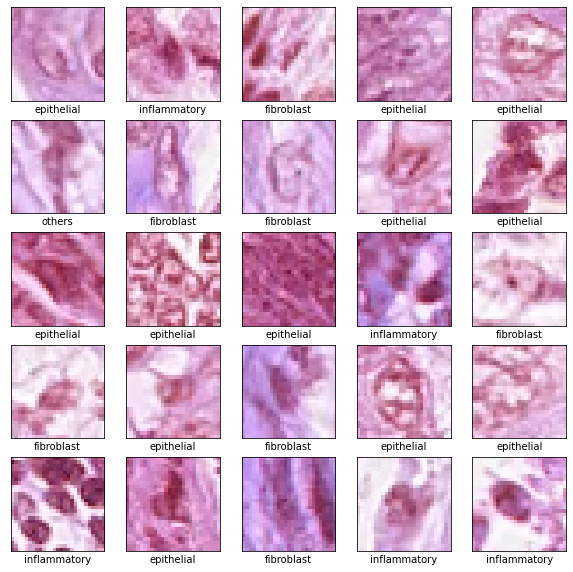

Epoch 1/15


2022-05-05 12:54:54.025128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


248/248 [==============================] - ETA: 0s - loss: 0.9878 - accuracy: 0.5934

2022-05-05 12:54:57.915474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


248/248 [==============================] - 5s 16ms/step - loss: 0.9878 - accuracy: 0.5934 - val_loss: 0.9111 - val_accuracy: 0.6343
Epoch 2/15
248/248 [==============================] - 4s 15ms/step - loss: 0.8070 - accuracy: 0.6834 - val_loss: 0.7392 - val_accuracy: 0.7283
Epoch 3/15
248/248 [==============================] - 4s 14ms/step - loss: 0.7275 - accuracy: 0.7121 - val_loss: 0.7349 - val_accuracy: 0.7116
Epoch 4/15
248/248 [==============================] - 4s 14ms/step - loss: 0.6944 - accuracy: 0.7292 - val_loss: 0.7672 - val_accuracy: 0.6934
Epoch 5/15
248/248 [==============================] - 4s 15ms/step - loss: 0.6733 - accuracy: 0.7365 - val_loss: 0.6968 - val_accuracy: 0.7328
Epoch 6/15
248/248 [==============================] - 4s 15ms/step - loss: 0.6263 - accuracy: 0.7532 - val_loss: 0.6601 - val_accuracy: 0.7449
Epoch 7/15
248/248 [==============================] - 4s 15ms/step - loss: 0.6000 - accuracy: 0.7662 - val_loss: 0.6796 - val_accuracy: 0.7399
Epoch 8/15

In [46]:
import matplotlib.pyplot as plt
all_class = ["epithelial", "fibroblast", "inflammatory", "others"]

def celltype_classify_data(class_list):    
    images = list()
    labels = list()
    
    for i, label in enumerate(class_list):
        # get image directory
        img_dir = os.path.join(root, f"{label}")
        
        for img in os.listdir(img_dir):
            img = cv2.imread(os.path.join(img_dir, img))
            # resize to 0-1 for faster computation
            resized = img / 255
            images.append(resized)
            labels.append(i)
        
    return (images, labels)

# print first 25 images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(all_class[y_train[i]])
plt.show()

def get_multiclass_model():
    model = tf.keras.Sequential()
    # First convo-pooling
    
    # Convolutional layers (filter the image with a kernel)
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=1,activation="relu", input_shape=[27, 27, 3]))
    # Max-pooling layers (reduce the size of the image by choosing max pixel at certain area)
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=1))
    
    # Convolutional layers (filter the image with a kernel)
    model.add(tf.keras.layers.Conv2D(64, (3, 3),strides=1, activation="relu"))
    # Max-pooling layers (reduce the size of the image by choosing max pixel at certain area)
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=1))
    
    # Flatten input
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation="relu"))
    model.add(tf.keras.layers.Dense(128, activation="relu"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    # Output layer
    model.add(tf.keras.layers.Dense(4, activation="softmax"))
    # Compile model 
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

cell_img, celltype_label = celltype_classify_data(all_class)
x_train, x_test, y_train, y_test = train_test_split(
    np.array(cell_img), np.array(celltype_label), test_size=0.2
)

model = get_multiclass_model()

model.fit(x_train, y_train, epochs=15, validation_data=(x_test, y_test))

Base CNN + ZCA whitening

In [45]:
# train data from ImageDataGenerator
datagen = ImageDataGenerator(
     zca_whitening=True,
)
datagen.fit(np.array(cell_img))

aug_train = datagen.flow(x_train, y_train, shuffle=True)
aug_val = datagen.flow(x_test, y_test, shuffle=True)

model = get_multiclass_model()
model.fit(aug_train, epochs=20, validation_data=aug_val)

Epoch 1/20


2022-05-05 12:38:04.478584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


248/248 [==============================] - ETA: 0s - loss: 1.3706 - accuracy: 0.4061

2022-05-05 12:38:23.959164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


248/248 [==============================] - 23s 91ms/step - loss: 1.3706 - accuracy: 0.4061 - val_loss: 1.2991 - val_accuracy: 0.4202
Epoch 2/20
248/248 [==============================] - 21s 85ms/step - loss: 1.3081 - accuracy: 0.4102 - val_loss: 1.2988 - val_accuracy: 0.4202
Epoch 3/20
248/248 [==============================] - 21s 86ms/step - loss: 1.2966 - accuracy: 0.4102 - val_loss: 1.2720 - val_accuracy: 0.4763
Epoch 4/20
248/248 [==============================] - 21s 86ms/step - loss: 1.0521 - accuracy: 0.5394 - val_loss: 1.0167 - val_accuracy: 0.5475
Epoch 5/20
248/248 [==============================] - 23s 92ms/step - loss: 0.9413 - accuracy: 0.5918 - val_loss: 0.9600 - val_accuracy: 0.5859
Epoch 6/20
248/248 [==============================] - 22s 90ms/step - loss: 0.8677 - accuracy: 0.6290 - val_loss: 0.9248 - val_accuracy: 0.5985
Epoch 7/20
248/248 [==============================] - 22s 88ms/step - loss: 0.8128 - accuracy: 0.6572 - val_loss: 0.9588 - val_accuracy: 0.5848
Epo

Base CNN + rotation

In [40]:
# train data from ImageDataGenerator
datagen = ImageDataGenerator(
     rotation_range=45,
)
datagen.fit(np.array(cell_img))

aug_train = datagen.flow(x_train, y_train, shuffle=True)
aug_val = datagen.flow(x_test, y_test, shuffle=True)

model = get_multiclass_model()
model.fit(aug_train, epochs=20, validation_data=aug_val)

Epoch 1/20


2022-05-05 12:25:33.117577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


248/248 [==============================] - ETA: 0s - loss: 1.0627 - accuracy: 0.5485

2022-05-05 12:25:36.867577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


248/248 [==============================] - 4s 16ms/step - loss: 1.0627 - accuracy: 0.5485 - val_loss: 0.9035 - val_accuracy: 0.6404
Epoch 2/20
248/248 [==============================] - 4s 15ms/step - loss: 0.8048 - accuracy: 0.6772 - val_loss: 0.7946 - val_accuracy: 0.6823
Epoch 3/20
248/248 [==============================] - 4s 15ms/step - loss: 0.7569 - accuracy: 0.6988 - val_loss: 0.7558 - val_accuracy: 0.7005
Epoch 4/20
248/248 [==============================] - 4s 15ms/step - loss: 0.7456 - accuracy: 0.6987 - val_loss: 0.7611 - val_accuracy: 0.6995
Epoch 5/20
248/248 [==============================] - 4s 15ms/step - loss: 0.7319 - accuracy: 0.7068 - val_loss: 0.8100 - val_accuracy: 0.6793
Epoch 6/20
248/248 [==============================] - 4s 15ms/step - loss: 0.7095 - accuracy: 0.7121 - val_loss: 0.6961 - val_accuracy: 0.7303
Epoch 7/20
248/248 [==============================] - 4s 15ms/step - loss: 0.7107 - accuracy: 0.7140 - val_loss: 0.7549 - val_accuracy: 0.6980
Epoch 8/20

### Multiclass using multiple models

In [88]:
def get_subclass_model():
    model = tf.keras.Sequential()
    # First convo-pooling
    # Convolutional layers (filter the image with a kernel)
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu", input_shape=[27, 27, 3]))
    # Max-pooling layers (reduce the size of the image by choosing max pixel at certain area)
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    # Flatten input
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation="relu"))
    model.add(tf.keras.layers.Dense(128, activation="relu"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    # Output layer
    model.add(tf.keras.layers.Dense(3, activation="softmax"))
    # Compile model 
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

def get_transfer_model():
    model = tf.keras.Sequential()
    # Flatten input
    model.add(tf.keras.layers.Flatten())
    # Hidden layers
    model.add(tf.keras.layers.Dense(256, activation="relu"))
    model.add(tf.keras.layers.Dense(128, activation="softmax"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    model.add(tf.keras.layers.Dense(3, activation="sigmoid"))
    # Output layer
    model.add(tf.keras.layers.Dense(4, activation="softmax"))
    # Compile model
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

sub_multiclass = ["epithelial", "fibroblast", "inflammatory"]

# imgs with 3 classes
subcell_img, subcelltype_label = celltype_classify_data(sub_multiclass)
subx_train, subx_test, suby_train, suby_test = train_test_split(
    np.array(subcell_img), np.array(subcelltype_label), test_size=0.2
)

print("---Subclass training---")
# train subclass that fit with 3 types of images
subclass_model = get_subclass_model()
subclass_model.fit(subx_train, suby_train, epochs=40, validation_data=(subx_test, suby_test))

---Subclass training---
Epoch 1/40


2022-05-06 12:10:09.713300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


213/213 [==============================] - ETA: 0s - loss: 0.6369 - accuracy: 0.7327

2022-05-06 12:10:11.779974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


213/213 [==============================] - 2s 10ms/step - loss: 0.6369 - accuracy: 0.7327 - val_loss: 0.5417 - val_accuracy: 0.7703
Epoch 2/40
213/213 [==============================] - 2s 9ms/step - loss: 0.5002 - accuracy: 0.8063 - val_loss: 0.4863 - val_accuracy: 0.8126
Epoch 3/40
213/213 [==============================] - 2s 9ms/step - loss: 0.4455 - accuracy: 0.8293 - val_loss: 0.4612 - val_accuracy: 0.8296
Epoch 4/40
213/213 [==============================] - 2s 9ms/step - loss: 0.4211 - accuracy: 0.8371 - val_loss: 0.4815 - val_accuracy: 0.8179
Epoch 5/40
213/213 [==============================] - 2s 9ms/step - loss: 0.3999 - accuracy: 0.8453 - val_loss: 0.4940 - val_accuracy: 0.8179
Epoch 6/40
213/213 [==============================] - 2s 9ms/step - loss: 0.3723 - accuracy: 0.8594 - val_loss: 0.5234 - val_accuracy: 0.7996
Epoch 7/40
213/213 [==============================] - 2s 9ms/step - loss: 0.3416 - accuracy: 0.8652 - val_loss: 0.5340 - val_accuracy: 0.8002
Epoch 8/40
213/2

### Multiclass + ANN

In [66]:
all_class = ["epithelial", "fibroblast", "inflammatory", "others"]
# imgs with 4 classes
cell_img, celltype_label = celltype_classify_data(all_class)
x_train, x_test, y_train, y_test = train_test_split(
    np.array(cell_img), np.array(celltype_label), test_size=0.2
)

# get transfered model and train with 4 types of images
transfer_x_train = subclass_model.predict(x_train)
transfer_x_test = subclass_model.predict(x_test)
transfer_model = get_transfer_model()

print("---Second model (4 classes model) training---")
transfer_model.fit(transfer_x_train, y_train, epochs=40, validation_data=(transfer_x_test, y_test))

---Second model (4 classes model) training---
Epoch 1/100
  1/248 [..............................] - ETA: 1:14 - loss: 1.3386 - accuracy: 0.4688

2022-05-06 10:41:10.093982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


248/248 [==============================] - ETA: 0s - loss: 1.1876 - accuracy: 0.4889

2022-05-06 10:41:11.898375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


248/248 [==============================] - 2s 8ms/step - loss: 1.1876 - accuracy: 0.4889 - val_loss: 0.9993 - val_accuracy: 0.5742
Epoch 2/100
248/248 [==============================] - 2s 7ms/step - loss: 0.8610 - accuracy: 0.8084 - val_loss: 0.7887 - val_accuracy: 0.8157
Epoch 3/100
248/248 [==============================] - 2s 7ms/step - loss: 0.7288 - accuracy: 0.8240 - val_loss: 0.7102 - val_accuracy: 0.8152
Epoch 4/100
248/248 [==============================] - 2s 7ms/step - loss: 0.6737 - accuracy: 0.8239 - val_loss: 0.6672 - val_accuracy: 0.8167
Epoch 5/100
248/248 [==============================] - 2s 7ms/step - loss: 0.6402 - accuracy: 0.8235 - val_loss: 0.6393 - val_accuracy: 0.8152
Epoch 6/100
248/248 [==============================] - 2s 7ms/step - loss: 0.6182 - accuracy: 0.8239 - val_loss: 0.6166 - val_accuracy: 0.8162
Epoch 7/100
248/248 [==============================] - 2s 7ms/step - loss: 0.6012 - accuracy: 0.8239 - val_loss: 0.6005 - val_accuracy: 0.8167
Epoch 8/100

248/248 [==============================] - 2s 7ms/step - loss: 0.5009 - accuracy: 0.8363 - val_loss: 0.5064 - val_accuracy: 0.8348
Epoch 59/100
248/248 [==============================] - 2s 7ms/step - loss: 0.5027 - accuracy: 0.8368 - val_loss: 0.5042 - val_accuracy: 0.8338
Epoch 60/100
248/248 [==============================] - 2s 7ms/step - loss: 0.5014 - accuracy: 0.8378 - val_loss: 0.5062 - val_accuracy: 0.8338
Epoch 61/100
248/248 [==============================] - 2s 7ms/step - loss: 0.5003 - accuracy: 0.8374 - val_loss: 0.5030 - val_accuracy: 0.8343
Epoch 62/100
248/248 [==============================] - 2s 7ms/step - loss: 0.5001 - accuracy: 0.8375 - val_loss: 0.5058 - val_accuracy: 0.8354
Epoch 63/100
248/248 [==============================] - 2s 7ms/step - loss: 0.5007 - accuracy: 0.8368 - val_loss: 0.5048 - val_accuracy: 0.8343
Epoch 64/100
248/248 [==============================] - 2s 7ms/step - loss: 0.5018 - accuracy: 0.8372 - val_loss: 0.5052 - val_accuracy: 0.8338
Epoch

### Stacked output from 3 classes and 4 models as meta-learner x

In [89]:
# imgs with 3 classes
subcell_img, subcelltype_label = celltype_classify_data(sub_multiclass)
subx_train, subx_test, suby_train, suby_test = train_test_split(
    np.array(subcell_img), np.array(subcelltype_label), test_size=0.2
)

# imgs with 4 classes
cell_img, celltype_label = celltype_classify_data(all_class)
x_train, x_test, y_train, y_test = train_test_split(
    np.array(cell_img), np.array(celltype_label), test_size=0.2
)

# get transfered model (3 classes model) and predict with 4 types of images
transfer_x_train = subclass_model.predict(x_train)
transfer_x_test = subclass_model.predict(x_test)

# get base model (4 classes model) and predict to get another x
base_x = model.predict(x_train)
base_x_test = model.predict(x_test)

stacked_x_train = np.concatenate((transfer_x_train, base_x), axis=1)
stack_x_test = np.concatenate((transfer_x_test, base_x_test), axis=1)

transfer_model = get_transfer_model()
transfer_model.fit(stacked_x_train, y_train, epochs=30, validation_data=(stack_x_test, y_test))

2022-05-06 12:11:50.782643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30
  1/248 [..............................] - ETA: 1:09 - loss: 1.3522 - accuracy: 0.4375

2022-05-06 12:11:52.899456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


246/248 [============================>.] - ETA: 0s - loss: 1.1610 - accuracy: 0.4967

2022-05-06 12:11:54.662435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


248/248 [==============================] - 2s 8ms/step - loss: 1.1598 - accuracy: 0.4984 - val_loss: 0.9044 - val_accuracy: 0.8379
Epoch 2/30
248/248 [==============================] - 2s 7ms/step - loss: 0.7957 - accuracy: 0.8181 - val_loss: 0.6837 - val_accuracy: 0.8328
Epoch 3/30
248/248 [==============================] - 2s 7ms/step - loss: 0.6686 - accuracy: 0.8181 - val_loss: 0.6076 - val_accuracy: 0.8354
Epoch 4/30
248/248 [==============================] - 2s 7ms/step - loss: 0.6148 - accuracy: 0.8196 - val_loss: 0.5656 - val_accuracy: 0.8318
Epoch 5/30
248/248 [==============================] - 2s 7ms/step - loss: 0.5754 - accuracy: 0.8204 - val_loss: 0.5261 - val_accuracy: 0.8359
Epoch 6/30
248/248 [==============================] - 2s 7ms/step - loss: 0.5444 - accuracy: 0.8216 - val_loss: 0.5001 - val_accuracy: 0.8359
Epoch 7/30
248/248 [==============================] - 2s 7ms/step - loss: 0.5190 - accuracy: 0.8215 - val_loss: 0.4763 - val_accuracy: 0.8354
Epoch 8/30
248/24

In [104]:
transfer_pred = transfer_model.predict(stack_x_test)

encoded_pred = list()
for pred in transfer_pred:
    encoded_pred.append(np.argmax(pred))
    
encoded_pred = np.array(encoded_pred)
print(classification_report(y_test, encoded_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       828
           1       0.91      0.90      0.91       382
           2       0.92      0.93      0.93       505
           3       0.82      0.78      0.80       265

    accuracy                           0.93      1980
   macro avg       0.91      0.90      0.90      1980
weighted avg       0.92      0.93      0.92      1980



### EDA

In [55]:
for i in range(4):
    print(f"No data in class {i} in data", (np.array(celltype_label)==i).sum())

No data in class 0 in data 4079
No data in class 1 in data 1888
No data in class 2 in data 2543
No data in class 3 in data 1386


### Multiclass + Oversampling + Decision tree

In [62]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

cell_img, celltype_label = celltype_classify_data(all_class)
transfered_x = subclass_model.predict(np.array(cell_img))

# by default, it would only over sample minority class which is the aim in this case
oversample = SMOTE()
transfered_x, celltype_label = oversample.fit_resample(transfered_x, np.array(celltype_label))

for i in range(4):
    print(f"No data in class {i} in oversampled data", (np.array(celltype_label)==i).sum())

x_train, x_test, y_train, y_test = train_test_split(
    transfered_x, celltype_label, test_size=0.2
)

tree_classifier = tree.DecisionTreeClassifier(class_weight="balanced")
tree_classifier = tree_classifier.fit(x_train, y_train)

forest_classifier = RandomForestClassifier(class_weight="balanced")
forest_classifier.fit(x_train, y_train)

tree_pred = tree_classifier.predict(x_test)
forest_pred = forest_classifier.predict(x_test)

print(classification_report(y_test, tree_pred))
print(classification_report(y_test, forest_pred))                                        

No data in class 0 in oversampled data 4079
No data in class 1 in oversampled data 4079
No data in class 2 in oversampled data 4079
No data in class 3 in oversampled data 4079
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       811
           1       0.74      0.88      0.80       789
           2       0.75      0.86      0.80       822
           3       0.67      0.43      0.52       842

    accuracy                           0.76      3264
   macro avg       0.75      0.77      0.75      3264
weighted avg       0.75      0.76      0.75      3264

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       811
           1       0.75      0.92      0.83       789
           2       0.76      0.89      0.82       822
           3       0.76      0.43      0.54       842

    accuracy                           0.79      3264
   macro avg       0.79      0.79      0.78      3264
weighted 